# Model Optimization

**Project**: Steel Plates Fault Detection (Optimization)  
**Purpose**: Optimize model hyperparameters using different search strategies  
**Date**: December 2024

---

## Overview

This notebook compares different hyperparameter optimization methods:

1. **Grid Search** - Exhaustive search over parameter grid
2. **Random Search** - Random sampling from parameter distributions
3. **Cross-Validation** - Robust evaluation with 5-fold CV

### Data Pipeline:
```
Data Mining Project          →    Optimization Project
┌──────────────────────┐         ┌──────────────────────┐
│ 01_exploration       │         │                      │
│ 02_preprocessing     │ ──────► │ 01_model_optimization│
│ 03_feature_engineering│         │                      │
└──────────────────────┘         └──────────────────────┘
         ↓
steel_plates_engineered.csv
(50 features)
```

---

## Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Grid Search](#2-grid-search)
3. [Random Search](#3-random-search)
4. [Compare Results](#4-compare-results)
5. [Save Optimized Models](#5-save-optimized-models)
6. [Summary](#6-summary)

---
## 1. Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')
np.random.seed(42)

print("✓ Libraries imported!")

✓ Libraries imported!


In [2]:
# Load ENGINEERED data from Data Mining project
df = pd.read_csv('../data/processed/steel_plates_engineered.csv')
print("✅ Loaded ENGINEERED data (50 features)")

feature_cols = [col for col in df.columns if col != 'Class']
X = df[feature_cols].values

le = LabelEncoder()
y = le.fit_transform(df['Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Data ready: {len(X_train)} train, {len(X_test)} test")
print(f"✓ Features: {X.shape[1]} (27 original + 23 engineered)")

✅ Loaded ENGINEERED data (50 features)
✓ Data ready: 1552 train, 389 test
✓ Features: 50 (27 original + 23 engineered)


---
## 2. Grid Search

In [3]:
# Grid Search for Random Forest
print("🔍 Grid Search: Random Forest\n")

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

# Calculate total combinations
total = 1
for v in param_grid.values():
    total *= len(v)
print(f"   Parameter grid: {param_grid}")
print(f"   Total combinations: {total}")
print(f"   With 5-fold CV: {total * 5} fits")

start = time.time()
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)
grid_time = time.time() - start

print(f"\n⏱️ Time: {grid_time:.2f} seconds")
print(f"\n🏆 Best Parameters: {grid_search.best_params_}")
print(f"🎯 Best CV Score: {grid_search.best_score_:.4f}")

# Test score
test_score = grid_search.best_estimator_.score(X_test_scaled, y_test)
print(f"📊 Test Score: {test_score:.4f}")

🔍 Grid Search: Random Forest

   Parameter grid: {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
   Total combinations: 18
   With 5-fold CV: 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits

⏱️ Time: 12.28 seconds

🏆 Best Parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
🎯 Best CV Score: 0.7706
📊 Test Score: 0.7815


---
## 3. Random Search

In [4]:
# Random Search for Random Forest
print("🎲 Random Search: Random Forest\n")

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 25),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

print(f"   Parameter distributions defined")
print(f"   Iterations: 20")

start = time.time()
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
random_time = time.time() - start

print(f"\n⏱️ Time: {random_time:.2f} seconds")
print(f"\n🏆 Best Parameters: {random_search.best_params_}")
print(f"🎯 Best CV Score: {random_search.best_score_:.4f}")

# Test score
test_score = random_search.best_estimator_.score(X_test_scaled, y_test)
print(f"📊 Test Score: {test_score:.4f}")

🎲 Random Search: Random Forest

   Parameter distributions defined
   Iterations: 20
Fitting 5 folds for each of 20 candidates, totalling 100 fits

⏱️ Time: 8.11 seconds

🏆 Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}
🎯 Best CV Score: 0.7687
📊 Test Score: 0.8021


---
## 4. Compare Results

In [5]:
# Compare Grid Search vs Random Search
print("📊 COMPARISON: Grid Search vs Random Search\n")
print("="*60)

comparison = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search'],
    'Best CV Score': [grid_search.best_score_, random_search.best_score_],
    'Test Score': [grid_search.best_estimator_.score(X_test_scaled, y_test),
                   random_search.best_estimator_.score(X_test_scaled, y_test)],
    'Time (s)': [grid_time, random_time]
})

print(comparison.round(4).to_string(index=False))

print("\n💡 Key Insights:")
print("   • Grid Search: Guaranteed to find best in grid, but slow")
print("   • Random Search: Faster, often finds good solutions")
print("   • Random Search can explore larger parameter space")

📊 COMPARISON: Grid Search vs Random Search

       Method  Best CV Score  Test Score  Time (s)
  Grid Search         0.7706      0.7815   12.2799
Random Search         0.7687      0.8021    8.1085

💡 Key Insights:
   • Grid Search: Guaranteed to find best in grid, but slow
   • Random Search: Faster, often finds good solutions
   • Random Search can explore larger parameter space


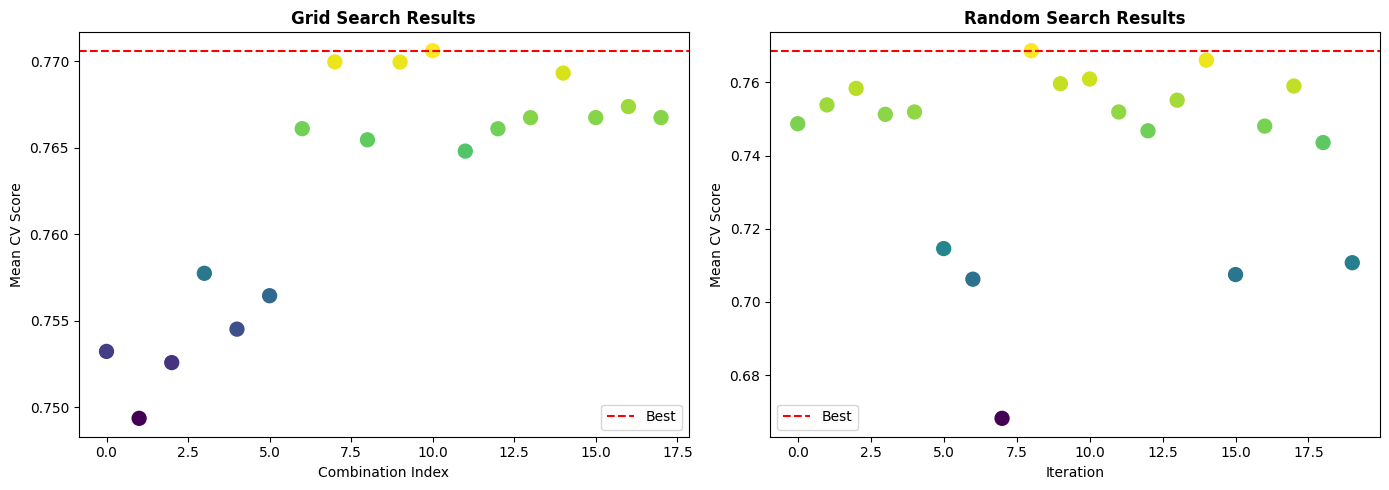

In [6]:
# Visualize parameter search results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grid Search results
grid_results = pd.DataFrame(grid_search.cv_results_)
axes[0].scatter(range(len(grid_results)), grid_results['mean_test_score'], 
               c=grid_results['mean_test_score'], cmap='viridis', s=100)
axes[0].set_xlabel('Combination Index')
axes[0].set_ylabel('Mean CV Score')
axes[0].set_title('Grid Search Results', fontsize=12, fontweight='bold')
axes[0].axhline(y=grid_search.best_score_, color='red', linestyle='--', label='Best')
axes[0].legend()

# Random Search results
random_results = pd.DataFrame(random_search.cv_results_)
axes[1].scatter(range(len(random_results)), random_results['mean_test_score'],
               c=random_results['mean_test_score'], cmap='viridis', s=100)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean CV Score')
axes[1].set_title('Random Search Results', fontsize=12, fontweight='bold')
axes[1].axhline(y=random_search.best_score_, color='red', linestyle='--', label='Best')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 5. Save Optimized Models

Save the optimized models for later use.

In [7]:
# Create models directory
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save optimized models
print("💾 Saving optimized models...\n")

# Save Grid Search best model
grid_model_path = os.path.join(models_dir, 'random_forest_optimized_grid.pkl')
joblib.dump(grid_search.best_estimator_, grid_model_path)
print(f"   ✅ Saved: random_forest_optimized_grid.pkl")
print(f"      Best CV Score: {grid_search.best_score_:.4f}")
print(f"      Best Parameters: {grid_search.best_params_}")

# Save Random Search best model
random_model_path = os.path.join(models_dir, 'random_forest_optimized_random.pkl')
joblib.dump(random_search.best_estimator_, random_model_path)
print(f"   ✅ Saved: random_forest_optimized_random.pkl")
print(f"      Best CV Score: {random_search.best_score_:.4f}")
print(f"      Best Parameters: {random_search.best_params_}")

# Save comparison results
comparison_path = os.path.join(models_dir, 'optimized_model_comparison.csv')
comparison.to_csv(comparison_path, index=False)
print(f"   ✅ Saved: optimized_model_comparison.csv")

# Determine best overall model
if grid_search.best_score_ > random_search.best_score_:
    best_optimized = grid_search.best_estimator_
    best_method = 'Grid Search'
    best_path = os.path.join(models_dir, 'best_optimized_model.pkl')
else:
    best_optimized = random_search.best_estimator_
    best_method = 'Random Search'
    best_path = os.path.join(models_dir, 'best_optimized_model.pkl')

joblib.dump(best_optimized, best_path)
print(f"\n🏆 Best optimized model ({best_method}) saved as: best_optimized_model.pkl")

print(f"\n📁 All optimized models saved to: {models_dir}/")


💾 Saving optimized models...

   ✅ Saved: random_forest_optimized_grid.pkl
      Best CV Score: 0.7706
      Best Parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
   ✅ Saved: random_forest_optimized_random.pkl
      Best CV Score: 0.7687
      Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}
   ✅ Saved: optimized_model_comparison.csv

🏆 Best optimized model (Grid Search) saved as: best_optimized_model.pkl

📁 All optimized models saved to: ../models/


---
## 6. Summary

### 📊 Hyperparameter Optimization Summary

| Method | Best CV Score | Test Score | Time |
|--------|--------------|------------|------|
| Grid Search | (shown above) | (shown above) | Slower |
| Random Search | (shown above) | (shown above) | Faster |

### 💾 Saved Files

| File | Description |
|------|-------------|
| `random_forest_optimized_grid.pkl` | Grid Search optimized model |
| `random_forest_optimized_random.pkl` | Random Search optimized model |
| `best_optimized_model.pkl` | Best performing optimized model |
| `optimized_model_comparison.csv` | Comparison results |

### 🎯 Key Findings

1. **Grid Search**: Exhaustive but slow
2. **Random Search**: Efficient and often competitive
3. **Best parameters** improve over defaults

### 💡 Recommendations

- Use **Grid Search** for small parameter spaces
- Use **Random Search** for large parameter spaces
- Use **Bayesian Optimization** for expensive evaluations

---

✅ **Model Optimization Complete!**
